In [ ]:
%tensorflow_version 2.x
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
%matplotlib inline

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=BTC&tsym=CAD&limit=500')
hist = pd.DataFrame(json.loads(res.content)['Data'])
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')
target_col = 'close'

In [ ]:
hist.head(5)

,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol
time,,,,,,,,
2021-07-12,43332.66,40546.21,42480.01,8119.51,3.415466e+08,41111.64,direct,
2021-07-13,41683.54,40182.18,41111.64,8079.27,3.310639e+08,40843.30,direct,
2021-07-14,41461.98,39425.62,40843.30,5772.57,2.337096e+08,41190.69,direct,
2021-07-15,41690.23,39149.66,41190.69,6310.66,2.531334e+08,39974.39,direct,
2021-07-16,40681.86,38953.38,39974.39,8833.83,3.530134e+08,39432.51,direct,


In [ ]:
hist.drop(["conversionType", "conversionSymbol"], axis = 'columns', inplace = True)

In [ ]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [ ]:
train, test = train_test_split(hist, test_size=0.2)

In [ ]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [CAD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

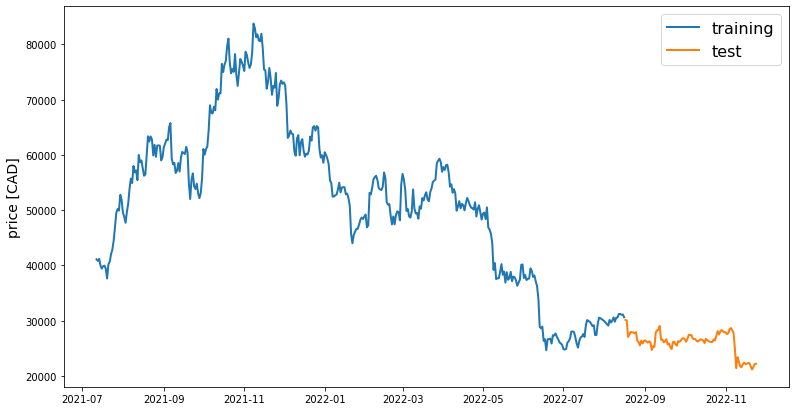

In [ ]:
line_plot(train[target_col], test[target_col], 'training', 'test', title='')

In [ ]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

In [ ]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [ ]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [ ]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [ ]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 20
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [ ]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [ ]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/20
13/13 [==============================] - 3s 9ms/step - loss: 0.0091
Epoch 2/20
13/13 [==============================] - 0s 8ms/step - loss: 0.0075
Epoch 3/20
13/13 [==============================] - 0s 8ms/step - loss: 0.0058
Epoch 4/20
13/13 [==============================] - 0s 7ms/step - loss: 0.0046
Epoch 5/20
13/13 [==============================] - 0s 7ms/step - loss: 0.0046
Epoch 6/20
13/13 [==============================] - 0s 8ms/step - loss: 0.0051
Epoch 7/20
13/13 [==============================] - 0s 7ms/step - loss: 0.0035
Epoch 8/20
13/13 [==============================] - 0s 8ms/step - loss: 0.0045
Epoch 9/20
13/13 [==============================] - 0s 8ms/step - loss: 0.0041
Epoch 10/20
13/13 [==============================] - 0s 8ms/step - loss: 0.0035
Epoch 11/20
13/13 [==============================] - 0s 8ms/step - loss: 0.0061
Epoch 12/20
13/13 [==============================] - 0s 7ms/step - loss: 0.0030
Epoch 13/20
13/13 [==============================

In [ ]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

3/3 [==============================] - 0s 5ms/step


0.022343522434497963

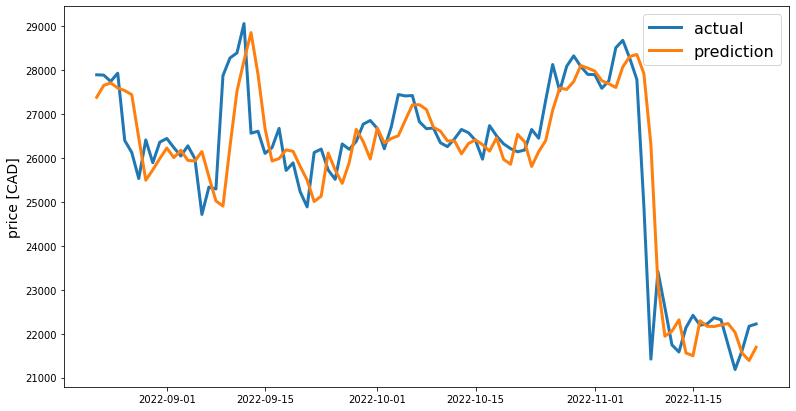

In [ ]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)

In [ ]:
from random import random
from numpy import array
from numpy import cumsum
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import Bidirectional

In [ ]:
modell = Sequential()
modell.add(Bidirectional(LSTM(100, activation='relu', input_shape=(100,1)))) #elu
modell.add(Dense(1))
modell.compile(loss='mean_squared_error', optimizer='adam') #rmsprop adam

In [ ]:
modell.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 200)              85600     
 l)                                                              
                                                                 
 dense_1 (Dense)             (None, 1)                 201       
                                                                 
Total params: 85,801
Trainable params: 85,801
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=30,
        verbose=1, mode='auto', restore_best_weights=True)

history1=modell.fit(X_train,y_train,validation_data=(X_test,y_test),
        callbacks=[monitor],verbose=1,epochs=1000)

Epoch 1/1000
13/13 [==============================] - 3s 45ms/step - loss: 35.5748 - val_loss: 0.0033
Epoch 2/1000
13/13 [==============================] - 0s 13ms/step - loss: 7.1497 - val_loss: 0.0032
Epoch 3/1000
13/13 [==============================] - 0s 12ms/step - loss: 2.2491 - val_loss: 0.0028
Epoch 4/1000
13/13 [==============================] - 0s 13ms/step - loss: 0.6787 - val_loss: 0.0028
Epoch 5/1000
13/13 [==============================] - 0s 13ms/step - loss: 0.0334 - val_loss: 0.0021
Epoch 6/1000
13/13 [==============================] - 0s 12ms/step - loss: 0.0096 - val_loss: 0.0021
Epoch 7/1000
13/13 [==============================] - 0s 12ms/step - loss: 0.0275 - val_loss: 0.0019
Epoch 8/1000
13/13 [==============================] - 0s 12ms/step - loss: 0.0212 - val_loss: 0.0019
Epoch 9/1000
13/13 [==============================] - 0s 13ms/step - loss: 0.0056 - val_loss: 0.0018
Epoch 10/1000
13/13 [==============================] - 0s 13ms/step - loss: 0.0024 - val_l

In [ ]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

3/3 [==============================] - 0s 5ms/step


0.021810721743994788

In [ ]:
modell.save("my_del.h5")

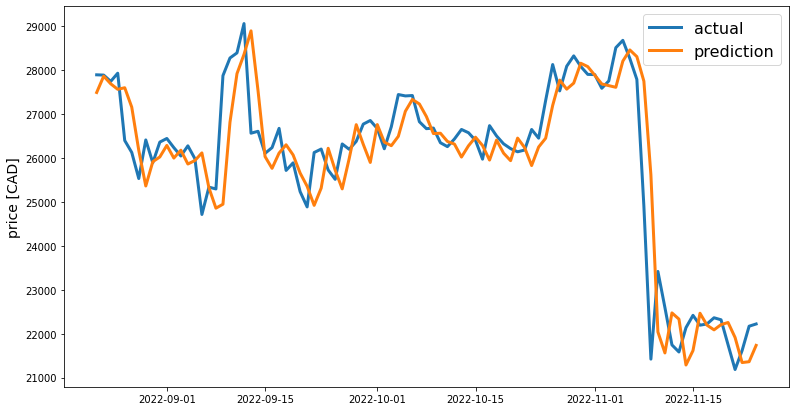

In [ ]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)